In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # 导入 LogNorm

%config InlineBackend.figure_format = 'svg'
config = {'font.family': 'Arial',
          'font.size': 12,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'mathtext.fontset': 'stix',
         }
plt.rcParams.update(config)

from utils import *

total_times = 121

def acquire_results(folder_name):
    results = np.load(f"./output/{folder_name}/results.npy")#.reshape(total_times, 19, 100, 400) # 时刻 种类
    n = np.load(f"./output/{folder_name}/results_porosity.npy")#.reshape(total_times, 100, 400)
    K = np.load(f"./output/{folder_name}/results_K.npy")#.reshape(total_times, 100, 400)
    return results, n, K

#  '0 K' '1 Na' '2 Ca' '3 Mg' '4 Li' '5 Cl' '6 S(6)' '7 C(4)' 
#  '8 Halite' '9 Carnallite' '10 Polyhalite' '11 Sylvite' '12 Gypsum'
#  '13 d_Halite' '14 d_Carnallite' '15 d_Polyhalite' '16 d_Sylvite' '17 d_Gypsum'
#  '18 density(kg/m3)'

# results_base, n_base, K_base = acquire_results(folder_name="var_0.1_seed_15795")
# results_base, n_base, K_base = acquire_results(folder_name="var_1.0_seed_860")
# results_base, n_base, K_base = acquire_results(folder_name="var_2.5_seed_76820")
# results_base, n_base, K_base = acquire_results(folder_name="acon")
# results_base, n_base, K_base = acquire_results(folder_name="mix_positive")
# results_base, n_base, K_base = acquire_results(folder_name="mix_negative")
# results_base, n_base, K_base = acquire_results(folder_name="sr_0.1_seed_14100")

# results_base = np.load(f"./output/sr_0.1_seed_14100/results.npy").reshape(total_times, 19, 100, 400)
# n_base = np.load(f"./output/sr_1.0_seed_49723/results_porosity.npy").reshape(total_times, 100, 400)
# K_base = np.load(f"./output/sr_1.0_seed_49723/results_K.npy").reshape(total_times, 100, 400)

In [40]:
K_base = np.load(f"./output/base/results_K.npy").reshape(total_times, 100, 400)

In [ ]:
results_base = np.load(
    "./output/sr_0.1_seed_14100/results.npy",
    mmap_mode="r"     # 'r' 表示只读；也可以用 'r+'（读写）、'c'（复制到写时拷贝）
)
results_base

0.00010000021931122482
2.930447038297101


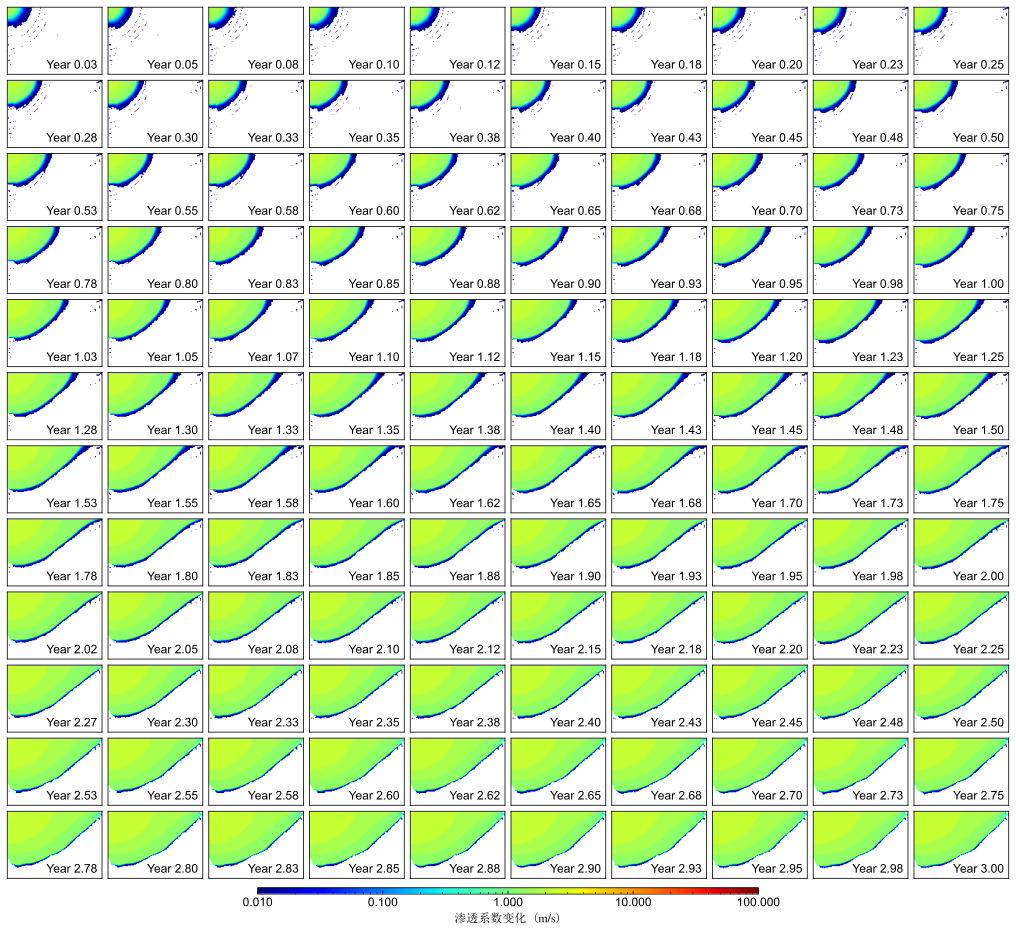

In [41]:


# data_to_plot_percent = [(K[i, :, :] - K[i-1, :, :])  for i in range(1, total_times, 1)] # / K[0, :, :] * 100
data_to_plot_percent = [(K_base[i, :, :] - K_base[0, :, :]) for i in range(1, total_times, 1)] # / K_base[0, :, :] * 100
# data_to_plot_percent = [(n[i, :, :] - n[0, :, :]) / n[0, :, :] * 100 for i in range(1, total_times, 1)]

# --- 对数处理的关键步骤 ---
# a. 处理非正值：将 <= 0 的值 mask 掉
data_to_plot_log = []
for arr_percent in data_to_plot_percent:
    # 构造掩码：值 <=0 或 <1e-3 的都设为 True（表示被 mask）
    mask = (arr_percent <= 0) | (arr_percent < 1e-4)
    masked_arr = np.ma.array(arr_percent, mask=mask)
    data_to_plot_log.append(masked_arr)

# b. 重新计算全局 vmin 和 vmax (只考虑未被 mask 的正值)
#    确保 vmin 是一个小的正数，vmax 是最大值
all_positive_values = np.concatenate([arr.compressed() for arr in data_to_plot_log])
log_vmin = np.min(all_positive_values)
log_vmax = np.max(all_positive_values)
if log_vmin < 1e-4: # 可以根据需要调整这个阈值
    log_vmin = 1e-4

print(log_vmin)
print(log_vmax)
log_vmin = 0.01
log_vmax = 100

n_rows, n_cols = 24, 10
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(14, 24),
    constrained_layout=True    # <— 打开 constrained_layout
)
axes = axes.flatten()
time_points = list(range(1, total_times, 1))
# 绘图循环
for idx, arr_log in enumerate(data_to_plot_log):
    ax = axes[idx]
    norm = LogNorm(vmin=log_vmin, vmax=log_vmax)
    mappable = ax.imshow(arr_log, cmap="jet", norm=norm, aspect='auto') # norm=norm, 
    # ax.set_title(f'K[{idx*2+1}] - K[0] (%)')
    ax.set_xticks([])
    ax.set_yticks([])

    # 计算当前时刻对应的“年”
    t = time_points[idx]       # 原始时刻编号：1,3,5,...
    year = t * (3.0/120)         # 0–9→1年；10–19→2年；20–29→3年

    # 在坐标轴的右下角添加文本
    ax.text(
        0.95, 0.05,      # 坐标轴内位置 (x, y)，右下角
        f'Year {year:.2f}',
        transform=ax.transAxes,
        fontdict={'family': 'Arial'},
        ha='right', va='bottom',
        fontsize=12,
        # color='white',
    )

# 删除多余的子轴
for ax in axes[len(data_to_plot_log):]:
    fig.delaxes(ax)

# 放 colorbar
cbar = fig.colorbar(
    mappable,
    ax=axes[:len(data_to_plot_log)].tolist(),
    location='bottom',
    pad=0.01,
    aspect=80,
    format='%.3f',
    shrink=0.5
)

cbar.set_label(r'渗透系数变化 ($\mathrm{m/s}$)', fontdict={'family': 'SimSun'})
# cbar.set_label(r'孔隙度变化比率 ($\mathrm{\%}$)', fontdict={'family': 'SimSun'})

plt.show()

In [15]:
data_to_plot_percent = np.array([(K_base[i, :, :]) for i in range(1, total_times, 1)] )
data_to = data_to_plot_percent.reshape(120, 40000)

In [ ]:
def calc_log_permeability_variance(K):
    
    return np.array([np.var(K[i, :, :]) for i in range(1, total_times, 1)])

plt.plot(calc_log_permeability_variance(K_base))
plt.plot(calc_log_permeability_variance(K_positive))
plt.plot(calc_log_permeability_variance(K_negative), color="green")


In [ ]:
_, _, K_positive = acquire_results(folder_name="mix_positive")
_, _, K_negative = acquire_results(folder_name="mix_negative")
_, _, K_base = acquire_results(folder_name="mix_base")

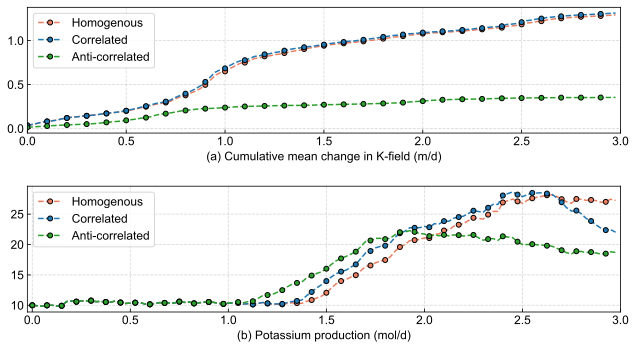

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_and_cumsum_chd_out(folder_path):
    file_path = os.path.join(folder_path, 'gwt_K_model.oc.csv')
    df = pd.read_csv(file_path)  # 简化示例，出错处理可按需加
    chd_out = df['CHD(SSM_CHD)_OUT'].fillna(0).astype(float)
    return np.array(chd_out)

def K_change_mean(K):
    changes = np.array([K[i] - K[i-1] for i in range(1, total_times)])
    flat = changes.reshape(changes.shape[0], -1)
    return flat.mean(axis=1)

# 假设 acquire_results 和 total_times 已定义
_, _, K_base     = acquire_results(folder_name="mix_base")
_, _, K_positive = acquire_results(folder_name="mix_positive")
_, _, K_negative = acquire_results(folder_name="mix_negative")

# 计算数据
m_base     = K_change_mean(K_base)
m_positive = K_change_mean(K_positive)
m_negative = K_change_mean(K_negative)

c_base     = np.cumsum(m_base)
c_positive = np.cumsum(m_positive)
c_negative = np.cumsum(m_negative)

labels = ['Homogenous', 'Correlated', 'Anti-correlated']
mycolors = ['#EB7E60', '#1f77b4', '#2ca02c']
markevery_value = 3

# —— 下面是两个子图 —— 
fig, axes = plt.subplots(2, 1, figsize=(9, 5))
ax1, ax2 = axes

# —— 第一个子图：累加均值变化 —— 
for data, color in zip([c_base, c_positive, c_negative], mycolors):
    ax1.plot(
        data,
        marker='o', markersize=5, linestyle='--',
        color=color, markeredgecolor="black",
        markevery=4,
    )
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_axisbelow(True)
ax1.legend(labels)
ax1.set_xlim(0, len(c_base))
ax1.set_xticks([0, 20, 40, 60, 80, 100, 120])
ax1.set_xticklabels([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax1.set_xlabel("(a) Cumulative mean change in K-field (m/d)")

# —— 第二个子图：CHD 输出 —— 
for path, color in zip(
        ["./simulation/mix_base", "./simulation/mix_positive", "./simulation/mix_negative"],
        mycolors):
    ax2.plot(
        read_and_cumsum_chd_out(path),
        marker='o', markersize=5, linestyle='--',
        color=color, markeredgecolor="black",
        markevery=markevery_value,
    )
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_axisbelow(True)
ax2.legend(labels)
ax2.set_xlim(-1, 120)
ax2.set_xticks([0, 20, 40, 60, 80, 100, 120])
ax2.set_xticklabels([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax2.set_xlabel("Times (year)")
ax2.set_xlabel(
    "(b) Potassium production (mol/d)",
)

plt.tight_layout(h_pad=2)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # 导入 LogNorm


kuangwuxinghao = 0
# 原始的百分比变化数据
data_to_plot_percent = [
    (results_base[i, kuangwuxinghao, :, :]) # / results_base[0, kuangwuxinghao, :, :] * 100.0    - results_base[0, kuangwuxinghao, :, :]
    for i in range(1, total_times, 1)]

# 计算全局的 vmin 和 vmax，便于统一色标
all_values = np.concatenate([arr.flatten() for arr in data_to_plot_percent])
vmin = np.min(all_values)
vmax = np.max(all_values)

# 布局
n_rows, n_cols = 24, 10
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(14, 24),
    constrained_layout=True    # <— 打开 constrained_layout
)
axes = axes.flatten()
time_points = list(range(1, total_times, 1))

# 绘图循环
for idx, arr in enumerate(data_to_plot_percent):
    ax = axes[idx]

    mappable = ax.imshow(
        arr,
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        aspect='auto',
        alpha=0.85,
    )
    # ax.set_title(f'K[{idx*2+1}] - K[0] (%)')
    ax.set_xticks([])
    ax.set_yticks([])

    # 计算当前时刻对应的“年”
    t = time_points[idx]       # 原始时刻编号：1,3,5,...
    year = t * (3.0/120)         # 0–9→1年；10–19→2年；20–29→3年

    # 在坐标轴的右下角添加文本
    ax.text(
        0.95, 0.05,      # 坐标轴内位置 (x, y)，右下角
        f'Year {year:.2f}',
        transform=ax.transAxes,
        fontdict={'family': 'Arial'},
        ha='right', va='bottom',
        fontsize=12,
        color='white',
    )
# 删除多余的子图
for ax in axes[len(data_to_plot_percent):]:
    fig.delaxes(ax)

# 添加 colorbar
cbar = fig.colorbar(
    mappable,
    ax=axes[:len(data_to_plot_percent)].tolist(),
    location='bottom',
    pad=0.01,
    aspect=80,
    format='%.3f',
    shrink=0.5
)
# cbar.set_label('Percentage Change (%)')

# 显示图像
plt.show()

In [ ]:
np.ones([100, 400])

In [ ]:
# --- 代码开始 ---


def calculate_total_potassium_leaching_efficiency(results, carn_threshold=0.1):
    """
    根据多维结果数组，计算所有时刻的总钾溶采效率：
      - 分母 init_raw：时刻0全网格（不剔除）的总钾量
      - 分子 dissolved：init_raw 减去阈值剔除后各时刻的总钾量

    参数:
      results (np.ndarray): 模拟结果数组，维度为 (time, species, rows, cols)。
                            物种索引: 9=光卤石, 10=杂卤石, 11=钾石盐。
      carn_threshold (float): 光卤石初始浓度阈值，低于该值的格点不参与后续光卤石计算。

    返回:
      np.ndarray: (time,) 的总钾溶采效率 (%)。
    """
    # 钾计量系数
    k_stoichiometry = {9: 1, 10: 2, 11: 1}

    # 提取各物种浓度
    carn_all = results[:, 9, :, :]   # 光卤石
    poly      = results[:,10, :, :]  # 杂卤石
    sylv      = results[:,11, :, :]  # 钾石盐

    # —— 1. 计算“未剔除”情况下时刻0的初始总钾量（denominator）
    init_raw = (
        np.sum(carn_all[0], axis=(0,1)) * k_stoichiometry[9] +
        np.sum(poly[0],      axis=(0,1)) * k_stoichiometry[10] +
        np.sum(sylv[0],      axis=(0,1)) * k_stoichiometry[11]
    )
    if init_raw == 0:
        print("警告：时刻0未剔除情况下的初始钾矿物含量为0，无法计算效率。")
        return np.zeros(results.shape[0])

    # —— 2. 构建光卤石阈值掩膜，仅对光卤石生效
    mask_carn = (carn_all[0] >= carn_threshold)

    # —— 3. 对“剔除后”各时刻的总钾量进行计算
    #    先把低浓度格点的光卤石浓度置 0，再累加
    carn_masked = carn_all * mask_carn
    total_k_masked = (
        np.sum(carn_masked, axis=(1,2)) * k_stoichiometry[9] +
        np.sum(poly,         axis=(1,2)) * k_stoichiometry[10] +
        np.sum(sylv,         axis=(1,2)) * k_stoichiometry[11]
    )

    # —— 4. 溶出量 = 原始初始总量 - 剔除后剩余总量
    dissolved = init_raw - total_k_masked

    # —— 5. 效率 = 溶出量 / 原始初始总量 * 100%
    efficiency = dissolved / init_raw * 100

    return efficiency

# --- 执行计算并打印结果 ---
total_potassium_efficiency_curve = calculate_total_potassium_leaching_efficiency(results_base)

# 打印前10个时刻的效率，看看效果
print("总钾溶采效率 (TPLE) 随时间变化曲线 (前10个时刻):")
# for t, efficiency in enumerate(total_potassium_efficiency_curve[:100]):
#     print(f"时刻 {t}: {efficiency:.2f}%")
print(total_potassium_efficiency_curve[39], total_potassium_efficiency_curve[79], total_potassium_efficiency_curve[119])
# 你也可以直接用matplotlib画图
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(total_potassium_efficiency_curve)
plt.title('Total Potassium Leaching Efficiency vs. Time')
plt.xlabel('Time Step')
plt.ylabel('Efficiency (%)')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def permeability_rate_curve(K, ax, i):
    K_initial = K[0, :, :]
    rate_of_change = np.abs((K[1:] - K[:-1]) / K_initial) * 100.0

    log_K_median = np.median(np.log(K_initial))
    print(f"Log-Permeability Median: {log_K_median}")

    high_permeability_mask = np.log(K_initial) >= log_K_median
    low_permeability_mask = ~high_permeability_mask

    # 计算高、低渗透区的平均变化率
    high_raw = np.mean(rate_of_change[:, high_permeability_mask], axis=1)
    low_raw = np.mean(rate_of_change[:, low_permeability_mask], axis=1)

    # # 3. 高斯滤波
    # gauss_sigma=3.0
    # high_g  = gaussian_filter1d(high_raw, sigma=gauss_sigma)
    # low_g   = gaussian_filter1d(low_raw,  sigma=gauss_sigma)
    # t_g     = np.arange(len(high_raw))

    # ——— 在这里给背景上色 ———
    # 左侧 0 ≤ x < 60
    ax.axvspan(0, 60,
               color='lightgray',   # 你也可以换成自己喜欢的浅色
               alpha=0.3,
               zorder=0)            # 确保背景在最下面
    # 右侧 60 ≤ x ≤ 120
    ax.axvspan(60, 120,
               color='lightyellow',
               alpha=0.3,
               zorder=0)
    
    if i == 0:
        ax.plot(high_raw, marker='o', markersize=3, label='Baseline K-field', color='black', alpha=0.7, linestyle='--')
        ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
    else:
        ax.plot(high_raw, marker='o', markersize=3, label='High K-field', color='firebrick', alpha=0.7, linestyle='--')
        ax.plot(low_raw, marker='o', markersize=3, label='Low K-field', color='navy', alpha=0.7, linestyle='--')
    # ax.plot(t_g, high_g, label='High Permeability Rate (Smoothed)', color='firebrick', linewidth=1.0)
    # ax.plot(t_g, low_g, label='Low Permeability Rate (Smoothed)', color='navy', linewidth=1.0)

    # plt.xlabel('Time Step')
    # plt.ylabel('Rate of Change in Permeability')
    # plt.legend()
    ax.grid(visible=True, which='major', axis='both', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    ax.set_ylim(0.5, 1.7)
    ax.set_xlim(0,120)

    ax.set_yticks([0.6, 1.0, 1.4])

    if i <= 2:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
        ax.set_xlabel('Times (year)')

    labels = ['(a) Base', '(b) Gaussian', '(c) CON', '(d) DCON']
    # 在右上角添加子图标签
    ax.text(0.95, 0.90, labels[i],
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=12,
    )

results_base, n_base, K_base = acquire_results(folder_name="base")
results_base, n_gaussian, K_gaussian = acquire_results(folder_name="gaussian")
results_base, n_acon, K_acon = acquire_results(folder_name="acon")
results_base, n_dcon, K_dcon = acquire_results(folder_name="dcon")

Ks = [K_base, K_gaussian, K_acon, K_dcon]

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharey=True)
i = 0
for ax, K in zip(axes, Ks):
    permeability_rate_curve(K, ax, i)
    i+=1
ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
ax.set_ylabel('Time Rate of Change (%)')
plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=0.0, wspace=0.0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def permeability_rate_curve(K, ax, i):
    K_initial = K[0, :, :]
    rate_of_change = K - K[0]

    # 取对数中值（只是打印用）
    log_K_median = np.median(np.log(K_initial))
    print(f"Log-Permeability Median: {log_K_median}")

    # 按初始渗透率分高低场
    high_mask = np.log(K_initial) >= 0
    low_mask  = ~high_mask

    # 计算平均累积变化率
    high_raw = np.mean(rate_of_change[:, high_mask], axis=1)
    low_raw  = np.mean(rate_of_change[:, low_mask], axis=1)

    # 时间点
    xs = np.array([40, 80, 120])

    # 先画曲线，放较低层
    if i == 0:
        ax.plot(high_raw, label='Baseline K-field',
                color='black', alpha=0.7, linestyle='--',
                zorder=1)
    else:
        ax.plot(high_raw, label='High K-field',
                color='firebrick', alpha=0.7, linestyle='--',
                zorder=1)
        ax.plot(low_raw,  label='Low K-field',
                color='navy',     alpha=0.7, linestyle='--',
                zorder=1)

    # 再画散点，并在上面加标注
    if i == 0:
        ys = high_raw[xs]
        ax.scatter(xs, ys,
                   color='black', s=40,
                   zorder=5)
    else:
        ys_high = high_raw[xs]
        ys_low  = low_raw[xs]
        ax.scatter(xs, ys_high,
                   color='firebrick', edgecolor='black', s=40,
                   zorder=5)
        ax.scatter(xs, ys_low,
                   color='navy',      edgecolor='black', s=40,
                   zorder=5)
        # 同时也可以对低场标注，自己按需打开下面这段
        # for x, y in zip(xs, ys_low):
        #     ax.text(x, y, f"{y:.2f}",
        #             ha='left', va='bottom',
        #             fontsize=8, zorder=6)

    # 标注高场散点数值
    for x, y in zip(xs, ys if i==0 else ys_high):
        ax.text(x, y,
                f"{y:.2f}",          # 累积变化率
                ha='left', va='bottom',
                fontsize=12,
                zorder=6)

    # 标注高场散点数值
    for x, y in zip(xs, ys if i==0 else ys_low):
        ax.text(x, y,
                f"{y:.2f}",          # 累积变化率
                ha='left', va='bottom',
                fontsize=12,
                zorder=6)
    # 网格和坐标设置
    ax.grid(True, which='major', axis='both',
            alpha=0.5, linestyle='--', zorder=0)
    ax.set_axisbelow(True)
    ax.set_xlim(0, 120)
    ax.set_xticks([0, 40, 80, 120])

    if i <= 2:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([0.0, 1.0, 2.0, 3.0])
        ax.set_xlabel('Times (year)')

    labels = ['(a) Base', '(b) Gaussian', '(c) CON', '(d) DCON']
    ax.text(0.05, 0.90, labels[i],
            transform=ax.transAxes,
            ha='left', va='top',
            fontsize=12)

# 主流程不变
results_base, n_base, K_base = acquire_results(folder_name="base")
results_base, n_gaussian, K_gaussian = acquire_results(folder_name="gaussian")
results_base, n_acon, K_acon = acquire_results(folder_name="acon")
results_base, n_dcon, K_dcon = acquire_results(folder_name="dcon")

Ks = [K_base, K_gaussian, K_acon, K_dcon]
fig, axes = plt.subplots(4, 1, figsize=(3, 6))

for i, (ax, K) in enumerate(zip(axes, Ks)):
    permeability_rate_curve(K, ax, i)

axes[-1].set_ylabel(r'Cumulative mean $\Delta$K (m/d)')
plt.subplots_adjust(hspace=0.0)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def gini_curve(K, ax, i):

    gini = calculate_gini_timeseries(K)

    ax.plot(gini, color="blue")

    # 网格和坐标设置
    ax.grid(True, which='major', axis='both',
            alpha=0.5, linestyle='--', zorder=0)
    ax.set_axisbelow(True)
    ax.set_xlim(0, 120)
    ax.set_xticks([0, 40, 80, 120])
    # ax.set_xticklabels([0.0, 1.0, 2.0, 3.0])
    ax.set_xlabel('Times (year)')

    labels = ['(a) Base', '(b) Gaussian', '(c) CON', '(d) DCON']
    ax.text(0.95, 0.05, labels[i],
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=12)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  

    # 垂直参考线：底部贴齐图框，顶部贴合曲线
    xs = [72, 55, 45, 68]
    x0 = xs[i]
    # 在 x0 处曲线实际数据值
    y0 = gini[int(x0)]
    # 数据坐标系的上下限
    y_min, y_max = ax.get_ylim()
    # 将曲线高度转换为轴坐标（0-1）范围
    y_frac = (y0 - y_min) / (y_max - y_min)
    ax.axvline(x0,
               color='black', linestyle='--',
               ymin=0, ymax=y_frac,
               zorder=3)
# 主流程不变
_, _, K_base = acquire_results(folder_name="base")
_, _, K_gaussian = acquire_results(folder_name="gaussian")
_, _, K_acon = acquire_results(folder_name="acon")
_, _, K_dcon = acquire_results(folder_name="dcon")

Ks = [K_base, K_gaussian, K_acon, K_dcon]
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

for i, (ax, K) in enumerate(zip(axes, Ks)):
    gini_curve(K, ax, i)

axes[0].set_ylabel(r'$\Delta$Gini of K')
plt.subplots_adjust(wspace=0.22)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

K = K_base
results = results_base

# K: permeability array with shape (time, y, x)
# results: array with shape (time, variables, y, x)

time = np.linspace(0, 3650, K.shape[0])[1:]  # analysis times (days)

# Indices for mineral changes and density in `results`
mineral_idxs = {
    'd_Halite': 13, # 8,
    'd_Carnallite': 14, # 9,
    'd_Polyhalite': 15,# 10,
    'd_Sylvite': 16, # 11,
    'd_Gypsum': 17, # 12,
}
density_idx = 18

# Compute stepwise changes
delta_K = K[1:] - K[0]
d_minerals = results[1:, list(mineral_idxs.values()), :, :]
delta_density = results[1:, density_idx, :, :] - results[0, density_idx, :, :]

# Prepare correlation storage
names = ['Initial_K'] + list(mineral_idxs.keys()) + ['Density']
corr = {n: [] for n in names}

# Flatten initial K once
# iK0 = K[0].flatten()

# Calculate Pearson r at each time step
timesteps = delta_K.shape[0]
for t in range(timesteps):
    prev_K_flat = K[t].flatten()      # 而不是固定 K[0]
    dK_flat = delta_K[t].flatten()
    corr['Initial_K'].append( pearsonr(dK_flat, prev_K_flat)[0])
    for i, name in enumerate(mineral_idxs):
        corr[name].append(pearsonr(dK_flat, d_minerals[t, i].flatten())[0])
    corr['Density'].append(pearsonr(dK_flat, delta_density[t].flatten())[0])

# Plot results
plt.figure(figsize=(14, 7))
for label, marker in [('Initial_K', 's'), ('Density', '^')] + [(n, 'o') for n in mineral_idxs]:
    plt.plot(time, corr[label], marker + '-', label=label, markersize=5, markeredgecolor='black', )

plt.xlabel('Simulation time (days)')
plt.ylabel('Pearson correlation coefficient')
plt.legend(bbox_to_anchor=(1.35, 1))
plt.grid(True, linestyle='--')
plt.ylim(-1, 1)
plt.xlim(0, 3655)
plt.tight_layout()
plt.show()
# 反应主导期 刚开始时矿物反应很活跃（如溶解打开孔隙，或沉淀堵塞通道），渗透率变化主要跟谁溶解/沉淀多有关
# 结构固化期 随着孔网结构被改造，新的高渗或低渗通道初步成型。此后，流体更倾向沿这些已成型通道流动，使得“哪里渗透率高，哪里变化更大”——也就是 K_prev 开始“占主导”
 